In [1]:
!tar -xzf test_technique.tar.gz --exclude=".*"

In [2]:
!pip install -q -U albumentations

In [8]:
import numpy as np
import os
import PIL
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from collections import Counter
import seaborn as sns
# import tensorflow_datasets as tfds
import albumentations as A
from functools import partial

import splitfolders

import tensorflow as tf
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Rescaling, Layer, BatchNormalization, InputLayer

from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

# AUTOTUNE = tf.data.experimental.AUTOTUNE
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [72]:
batch_size = 16
img_width = 256
img_height = 256

path = os.path.abspath('./Test_Technique_Image/Neuroflux_disorder/')
outpath = './Test_Technique_Image'
classes = os.listdir(path)
classes

['EO', 'IO', 'IPTE', 'LO', 'PTE']

In [9]:
splitfolders.ratio(path,
                    output='./Test_Technique_Image',
                    seed=42,
                    ratio=(.7, .2, .1),
                    group_prefix=None,
                    move=True
                    )

Error: Destination path './Test_Technique_Image\train\EO\neuroflux_127_S_1427_MR_Axial_T2_Star__br_raw_20181015144433143_22_S736345_I1059959.jpg' already exists

In [10]:
train_path = outpath + "\\train" 
val_path = outpath + "\\val" 
test_path = outpath + "\\test" 

In [122]:
image_gen = ImageDataGenerator(
                                  rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,
                               )

test_data_gen = ImageDataGenerator(rescale = 1./255)

In [126]:
from tensorflow.python.framework.op_def_library_pybind import process_inputs
from keras.api._v2.keras import preprocessing



train_ds = image_gen.flow_from_directory(
    train_path,
    seed=42,
    shuffle=True,
    batch_size=batch_size,
    )

val_ds = image_gen.flow_from_directory(
    val_path,
    seed=42,
    shuffle=True,
    batch_size=batch_size
    )

test_ds = test_data_gen.flow_from_directory(
    test_path,
    seed=123,
    batch_size=batch_size
    )

Found 906 images belonging to 5 classes.
Found 258 images belonging to 5 classes.
Found 132 images belonging to 5 classes.


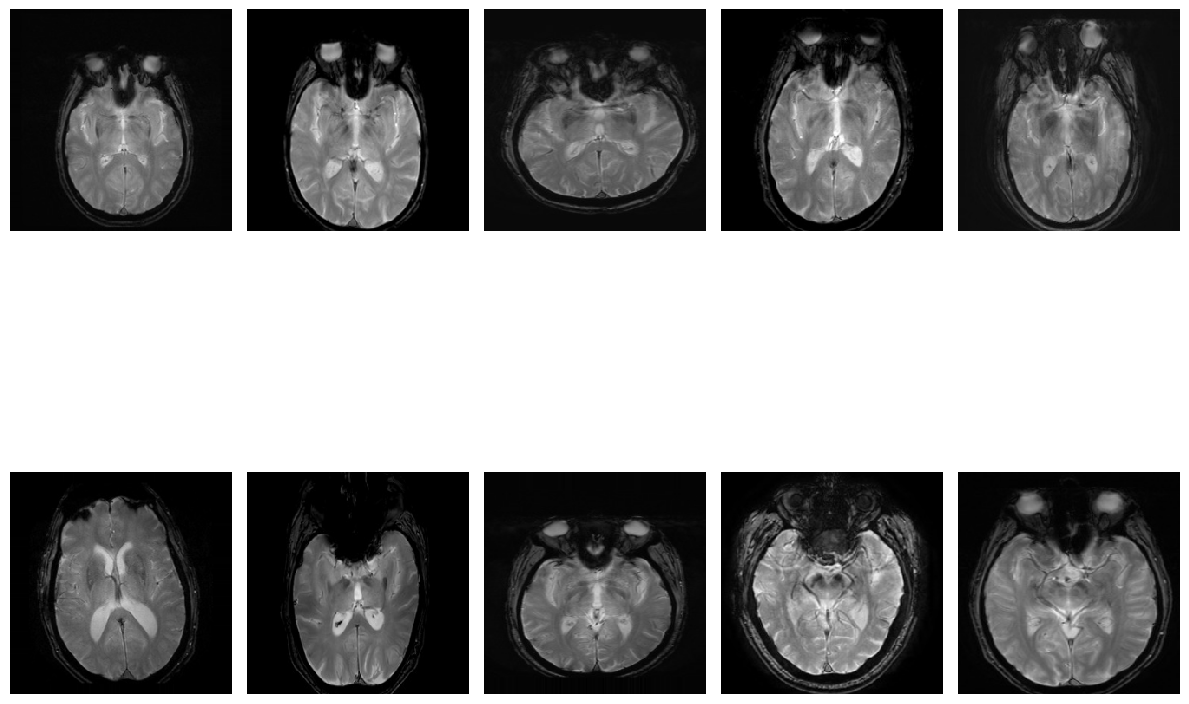

In [127]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train_ds:
        image = X_batch[0]        
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

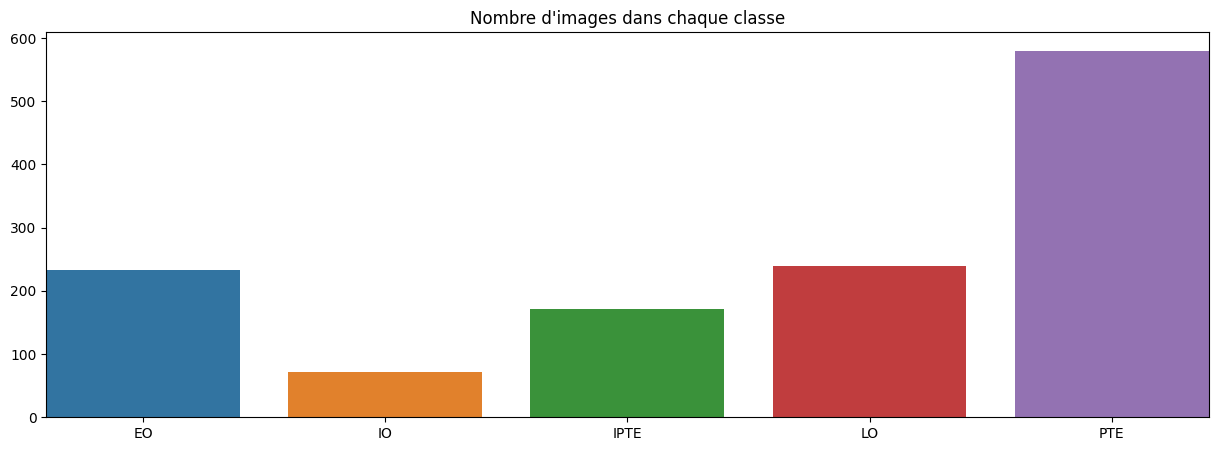

In [141]:
# ------------- Liste des classes et leur représentation dans le dataset -------------
classes_and_number = sorted(counts.items(), key = lambda x: x[1], reverse = True)[:13]

Y = []
for c in classes:
    if c in labels:
        dir_path = os.path.join(path, c)
        label = labels.index(c)
        for i in os.listdir(dir_path):
            Y.append(label)


# ------------- Liste des labels -------------

obj = Counter(Y)

fig = plt.figure(figsize = (15, 5))
sns.barplot(x = [labels[i] for i in obj.keys()], y = list(obj.values())).set_title("Nombre d'images dans chaque classe")
plt.margins(x = 0)
plt.show()

In [128]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 3)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(BatchNormalization())

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 3)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Dropout(0.4))

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 3)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Dropout(0.3))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 3)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(BatchNormalization())

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 3)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Dropout(0.2))


cnn.add(Flatten())

# cnn.add(Dense(activation = 'relu', units = 512))
cnn.add(Dense(activation = 'relu', units = 256))
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'softmax', units = 5))

cnn.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy', 'Recall'])

In [129]:
early = EarlyStopping(monitor='val_loss', mode='min', patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.01)
callbacks_list = [ early, learning_rate_reduction]

In [130]:
counts = {}
total_files = 0
maxi = 0
for c in classes:
    length = len(os.listdir(os.path.join(path, c)))
    if length > maxi :
        maxi = length
    counts[c] = length
    total_files += length
    
for k, v in counts.items():
    counts[k] = (v / maxi)

coeff = {}
for i in range(len(counts)):
    coeff[i] = counts[classes[i]]
    
coeff

{0: 0.4017241379310345,
 1: 0.12413793103448276,
 2: 0.29482758620689653,
 3: 0.41379310344827586,
 4: 1.0}

In [132]:
x = cnn.fit(train_ds,epochs=5, validation_data=val_ds, class_weight = coeff) #, callbacks=callbacks_list)

Epoch 1/5
57/57 [==============================] - 44s 770ms/step - loss: 0.6365 - accuracy: 0.4481 - recall: 0.4415 - val_loss: 1.5470 - val_accuracy: 0.4496 - val_recall: 0.4496
Epoch 2/5
57/57 [==============================] - 43s 758ms/step - loss: 0.6419 - accuracy: 0.4481 - recall: 0.4305 - val_loss: 1.4529 - val_accuracy: 0.4496 - val_recall: 0.4496
Epoch 3/5
57/57 [==============================] - 43s 744ms/step - loss: 0.6406 - accuracy: 0.4481 - recall: 0.4404 - val_loss: 1.5144 - val_accuracy: 0.4496 - val_recall: 0.4496
Epoch 4/5
57/57 [==============================] - 42s 742ms/step - loss: 0.6333 - accuracy: 0.4481 - recall: 0.4382 - val_loss: 1.5040 - val_accuracy: 0.4496 - val_recall: 0.3178
Epoch 5/5
57/57 [==============================] - 45s 785ms/step - loss: 0.6246 - accuracy: 0.4481 - recall: 0.4294 - val_loss: 1.9131 - val_accuracy: 0.4496 - val_recall: 0.4496


In [136]:
score = cnn.evaluate(test_ds)

9/9 [==============================] - 2s 187ms/step - loss: 1.9309 - accuracy: 0.4394 - recall: 0.4394


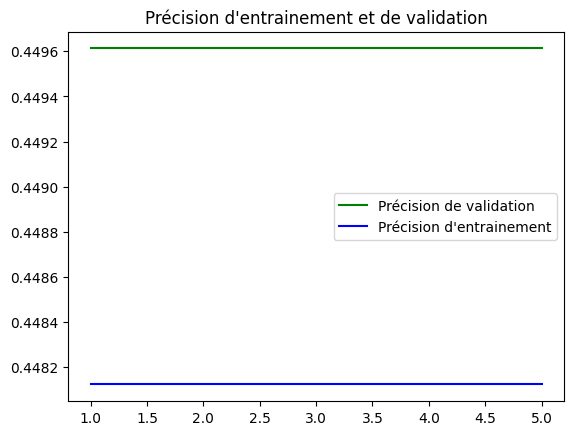

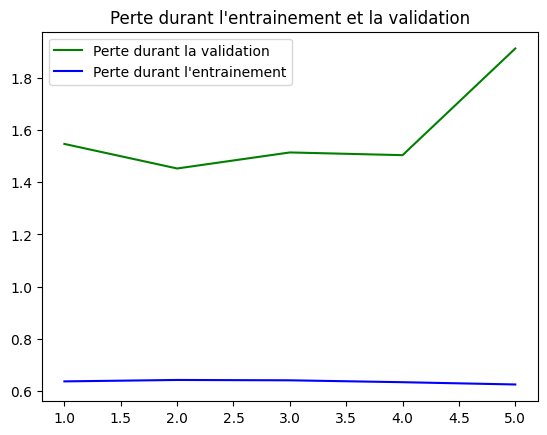

In [142]:
def training_plot(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, val_acc, 'g', label="Précision de validation")
    plt.plot(epochs, acc, 'b', label="Précision d'entrainement")
    plt.title("Précision d'entrainement et de validation")
    plt.legend()
    plt.figure()
    plt.plot(epochs, val_loss, 'g', label="Perte durant la validation")
    plt.plot(epochs, loss, 'b', label="Perte durant l'entrainement")
    plt.title("Perte durant l'entrainement et la validation")
    plt.legend()
    plt.show()

training_plot(x)